Here, we are going to look at dimensionality reduction as a preprocessing technique for images.

Before we start, why might you do this? Well the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) tells us that the more features we have then the more data we need to train a good model. Expanding on this, if you have a fixed amount of training data (which is often the case) your model's accuracy will decrease for every feature you have.

For images, we think of the number of features as the number of pixels. So for a 64x64 image we have 4096 features! One way to reduce that number (and hopefully produce a more accurate model) is to effectively compress the image. We do this by trying to find a way of keeping as much information as possible about the image without losing the essential structure.

For the example in this notebook, we're going to use [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis) and the Sign Language Digits classification dataset.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA

X = np.load(r"C:\Users\malar\Downloads\Compressed\X.npy\X.npy")
Y = np.load(r"C:\Users\malar\Downloads\Y.npy")

X.shape

(2062, 64, 64)

So as I said before the Sign-language-digits-dataset is formed of 2062 images, each 64x64.

Let's have a look at what that looks like:

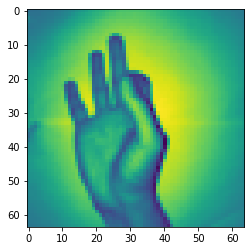

In [3]:
plt.imshow(X[0])

the `Y` dataset here gives us the labels for these images, it's kind of weirdly ordered and this image represents the number

In [4]:
9 - np.argmax(Y[0])

9

To start with let's flatten our data into 2062 4096 dim vectors and split the dataset into training and testing sets.

In [5]:
X_flat = np.array(X).reshape((2062, 64*64))

X_train, X_test, y_train, y_test = train_test_split(X_flat, Y, test_size=0.3, random_state=42)

To demonstrate how dimensionality reduction can improve the results of a model we need a model. Here is a very basic, fully connected neural net

This is deliberately not a great model and I'm not going to tune the hyper-parameters. We only need this as a benchmark for later

In [6]:
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(20, 20, 20), random_state=1)
clf.fit(X_train, y_train)

C:\Users\malar\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [7]:
y_hat = clf.predict(X_test)

print("accuracy: " + str(accuracy_score(y_test, y_hat)))

accuracy: 0.3360258481421648


As you can see, this is a pretty poor model, only achieving ~30% overall accuracy on the test set.

We're now goint to reduce the dimension of our training data and then retrain what we have.

The objective here is going to be to reduce the number of dimensions of the image, but before we do that we need to decide what we want to reduce it to. To do that we're going to try and find the number of dimensions that keeps 95% of the variance of the original images.

In [8]:
pca_dims = PCA()
pca_dims.fit(X_train)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [9]:
d

292

Wow - so we've gone from 4096 dimensions to just 292! But how good is this actually?

Let's train PCA on our training set and transform the data, then print out an example

In [10]:
pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [11]:
print("reduced shape: " + str(X_reduced.shape))
print("recovered shape: " + str(X_recovered.shape))

reduced shape: (1443, 292)
recovered shape: (1443, 4096)


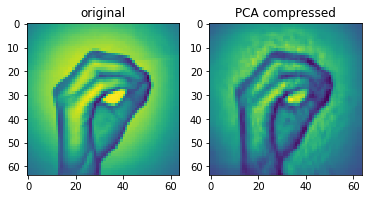

In [12]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.title("original")
plt.imshow(X_train[0].reshape((64,64)))
f.add_subplot(1,2, 2)

plt.title("PCA compressed")
plt.imshow(X_recovered[0].reshape((64,64)))
plt.show(block=True)

You can see it's far from perfect, but it's still clear what shape the hand is making

Let's retrain our model with the dimensionally reduced training data:

In [13]:
clf_reduced = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(20, 20, 20))
clf_reduced.fit(X_reduced, y_train)

C:\Users\malar\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [14]:
X_test_reduced = pca.transform(X_test)

y_hat_reduced = clf_reduced.predict(X_test_reduced)

print("accuracy: " + str(accuracy_score(y_test, y_hat_reduced)))

accuracy: 0.6155088852988692


And as you can see we've taken this simple model from ~30% accuracy on the test set to ~65%



**EDIT**

Some dependency has changed and I've changed the architecture of the NN here slightly, but the point remains the same